In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")
import numpy as np
from typing import Dict, Tuple

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import validation_curve, learning_curve

from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from IPython.display import Image
from io import StringIO 

import graphviz 
import pydotplus

In [2]:
data = pd.read_csv('data/Admission_Predict_Ver1.1.csv', sep=',')

In [3]:
data.shape

(500, 9)

In [4]:
data.info()
data.drop(columns=data.columns[0], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


In [5]:
data.duplicated().sum()

0

In [6]:
col_num = data.dtypes[data.dtypes!=object].index.values.tolist()
col_num.remove("Chance of Admit ")
se = StandardScaler()
data[col_num] = se.fit_transform(data[col_num])

In [7]:
data.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1.819238,1.778865,0.775582,1.137360,1.098944,1.776806,0.886405,0.92
1,0.667148,-0.031601,0.775582,0.632315,1.098944,0.485859,0.886405,0.76
2,-0.041830,-0.525364,-0.099793,-0.377773,0.017306,-0.954043,0.886405,0.72
3,0.489904,0.462163,-0.099793,0.127271,-1.064332,0.154847,0.886405,0.80
4,-0.219074,-0.689952,-0.975168,-1.387862,-0.523513,-0.606480,-1.128152,0.65


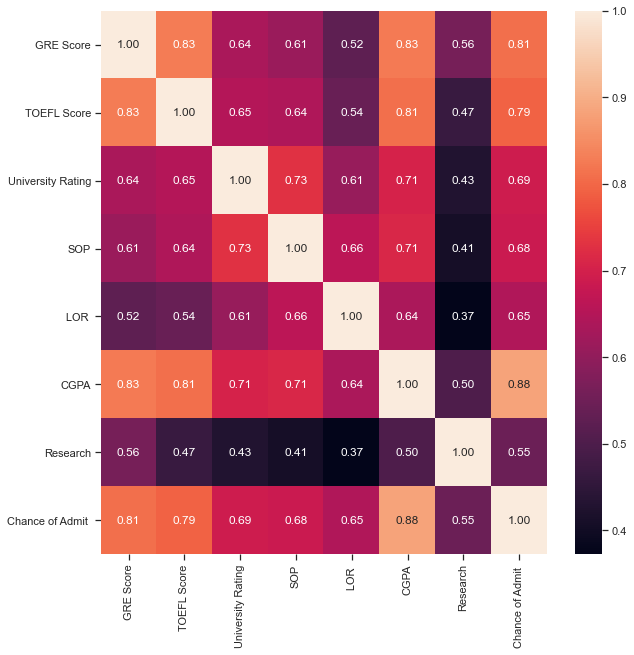

In [8]:
plt.figure(figsize=(10,10))
g = sns.heatmap(data.corr(), annot=True, fmt='.2f')

In [9]:
data.corr()["TOEFL Score"].sort_values(ascending=False)

TOEFL Score          1.000000
GRE Score            0.827200
CGPA                 0.810574
Chance of Admit      0.792228
University Rating    0.649799
SOP                  0.644410
LOR                  0.541563
Research             0.467012
Name: TOEFL Score, dtype: float64

In [10]:
data.corr()["GRE Score"].sort_values(ascending=False)

GRE Score            1.000000
TOEFL Score          0.827200
CGPA                 0.825878
Chance of Admit      0.810351
University Rating    0.635376
SOP                  0.613498
Research             0.563398
LOR                  0.524679
Name: GRE Score, dtype: float64

In [11]:
data.corr()["CGPA"].sort_values(ascending=False)

CGPA                 1.000000
Chance of Admit      0.882413
GRE Score            0.825878
TOEFL Score          0.810574
SOP                  0.712154
University Rating    0.705254
LOR                  0.637469
Research             0.501311
Name: CGPA, dtype: float64

Было выявлено 3 сильно связанных признака

Поскольку они сильно корелируют с целевым, проведем обучение моделей с удалением и посмотрим результаты

In [12]:
TEST_SIZE = 0.3
RANDOM_STATE = 0
SPLITS_DEFAULT = 5
CROSS_VAL = StratifiedKFold(n_splits=SPLITS_DEFAULT)

In [13]:
data_deleted1 = data.drop(columns='TOEFL Score')
data_deleted2 = data.drop(columns= ["TOEFL Score", "GRE Score"])

In [14]:
data_X = data.drop(columns='Chance of Admit ')
data_Y = data['Chance of Admit ']
data_d1_X = data_deleted1.drop(columns='Chance of Admit ')
data_d1_Y = data_deleted1['Chance of Admit ']
data_d2_X = data_deleted2.drop(columns='Chance of Admit ')
data_d2_Y = data_deleted2['Chance of Admit ']

In [15]:
data_X_train, data_X_test, data_Y_train, data_Y_test = train_test_split \
(data_X, data_Y, test_size = TEST_SIZE, random_state = RANDOM_STATE)
data_d1_X_train, data_d1_X_test, data_d1_Y_train, data_d1_Y_test = train_test_split \
(data_d1_X, data_d1_Y, test_size = TEST_SIZE, random_state = RANDOM_STATE)
data_d2_X_train, data_d2_X_test, data_d2_Y_train, data_d2_Y_test = train_test_split \
(data_d2_X, data_d2_Y, test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [16]:
def print_metrics(X_train, Y_train, X_test, Y_test, clf):
    clf.fit(X_train, Y_train)
    target = clf.predict(X_test)
    ret = (mean_squared_error(Y_test, target), median_absolute_error(Y_test, target))
    print(f'RMSE: {ret[0]}, MedianAE: {ret[1]}')
    return ret

# Регрессия

## Вся таблица

In [17]:
from sklearn.linear_model import ElasticNet
from numpy import array
grid = RandomizedSearchCV(estimator=ElasticNet(), param_distributions=[{'l1_ratio': uniform(loc=0, scale=1)}], cv=100, scoring='neg_mean_squared_error')
grid.fit(data_X_train, data_Y_train)
print(f'Best Param = {grid.best_params_}, score = {grid.best_score_}')

Best Param = {'l1_ratio': 0.08224605342330327}, score = -0.013796249317372665


In [18]:
regression_full = print_metrics(data_X_train, data_Y_train,  data_X_test, data_Y_test, ElasticNet(l1_ratio=grid.best_params_.get('l1_ratio')))

RMSE: 0.012509480789876208, MedianAE: 0.0670421353882204


## Удален 1 

In [19]:
grid = RandomizedSearchCV(estimator=ElasticNet(), param_distributions=[{'l1_ratio': uniform(loc=0, scale=1)}], cv=100, scoring='neg_mean_squared_error')
grid.fit(data_X_train, data_Y_train)
grid.fit(data_d1_X_train, data_d1_Y_train)
print(f'Best Param = {grid.best_params_}, score = {grid.best_score_}')

Best Param = {'l1_ratio': 0.9498787300013933}, score = -0.020902440142821548


In [20]:
regression_d1 = print_metrics(data_d1_X_train, data_d1_Y_train,  data_d1_X_test, data_d1_Y_test, ElasticNet(l1_ratio=grid.best_params_.get('l1_ratio')))

RMSE: 0.018688403265306124, MedianAE: 0.08805714285714283


## Удалено 2 

In [21]:
grid = RandomizedSearchCV(estimator=ElasticNet(), param_distributions=[{'l1_ratio': uniform(loc=0, scale=1)}], cv=100, scoring='neg_mean_squared_error')
grid.fit(data_X_train, data_Y_train)
grid.fit(data_d2_X_train, data_d2_Y_train)
print(f'Best Param = {grid.best_params_}, score = {grid.best_score_}')

Best Param = {'l1_ratio': 0.07948572653280905}, score = -0.014904377570684942


In [22]:
regression_d2 = print_metrics(data_d2_X_train, data_d2_Y_train,  data_d2_X_test, data_d2_Y_test, ElasticNet(l1_ratio=grid.best_params_.get('l1_ratio')))

RMSE: 0.013439982411958144, MedianAE: 0.07315560776015928


In [23]:
print(f'Полная :{regression_full}')
print(f'Без TOEFL :{regression_d1}')
print(f'Без CGPA :{regression_d2}')

Полная :(0.012509480789876208, 0.0670421353882204)
Без TOEFL :(0.018688403265306124, 0.08805714285714283)
Без CGPA :(0.013439982411958144, 0.07315560776015928)


Выгоднее оставлять полный набор при регрессии

# SVR

## Вся таблица

In [24]:
grid = GridSearchCV(estimator=SVR(kernel='poly'), param_grid=[{'degree': array([1, 2, 3, 4])}], cv=10, scoring='neg_mean_squared_error')
grid.fit(data_X_train, data_Y_train)
print(f'Best Param = {grid.best_params_}, score = {grid.best_score_}')

Best Param = {'degree': 1}, score = -0.004299519020403193


In [25]:
SVR_full = print_metrics(data_X_train, data_Y_train,  data_X_test, data_Y_test, SVR(kernel='poly', degree=grid.best_params_.get('degree')))

RMSE: 0.004670952294593802, MedianAE: 0.04886169568948162


## Удален 1 

In [26]:
grid = GridSearchCV(estimator=SVR(kernel='poly'), param_grid=[{'degree': array([1, 2, 3, 4])}], cv=10, scoring='neg_mean_squared_error')
grid.fit(data_d1_X_train, data_d1_Y_train)
print(f'Best Param = {grid.best_params_}, score = {grid.best_score_}')

Best Param = {'degree': 1}, score = -0.004583961888149202


In [27]:
SVR_d1 = print_metrics(data_d1_X_train, data_d1_Y_train,  data_d1_X_test, data_d1_Y_test, SVR(kernel='poly', degree=grid.best_params_.get('degree')))

RMSE: 0.004856996757379799, MedianAE: 0.05145831076268981


## Удалено 2 

In [28]:
grid = GridSearchCV(estimator=SVR(kernel='poly'), param_grid=[{'degree': array([1, 2, 3, 4])}], cv=10, scoring='neg_mean_squared_error')
grid.fit(data_d2_X_train, data_d2_Y_train)
print(f'Best Param = {grid.best_params_}, score = {grid.best_score_}')

Best Param = {'degree': 1}, score = -0.004819888838668563


In [29]:
SVR_d2 = print_metrics(data_d2_X_train, data_d2_Y_train,  data_d2_X_test, data_d2_Y_test, SVR(kernel='poly', degree=grid.best_params_.get('degree')))

RMSE: 0.005274152109453729, MedianAE: 0.05562094598525846


In [30]:
print(f'Полная :{SVR_full}')
print(f'Без TOEFL :{SVR_d1}')
print(f'Без CGPA :{SVR_d2}')

Полная :(0.004670952294593802, 0.04886169568948162)
Без TOEFL :(0.004856996757379799, 0.05145831076268981)
Без CGPA :(0.005274152109453729, 0.05562094598525846)


Выгоднее оставлять полный набор при SVM

# Деревья решений

In [31]:
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

In [32]:
def show_feature_importance(importance, col_names):
    data = pd.DataFrame({'feature_names':np.array(col_names),'feature_importance':np.array(importance)})
    data.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,7))
    sns.barplot(x=data['feature_importance'], y=data['feature_names'])
    plt.title('Feature importance using DecisionTreeClassifier')
    plt.xlabel('importance')
    plt.ylabel('name')

## полное

In [33]:
params = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [0.04, 0.06, 0.08],
    'max_features': [0.2, 0.4, 0.6, 0.8]
}

In [34]:
grid = GridSearchCV(estimator = DecisionTreeRegressor(random_state=1), param_grid=params, cv=10, scoring='neg_mean_squared_error')
grid.fit(data_X_train, data_Y_train)
print(f'Best Param = {grid.best_params_}, score = {grid.best_score_}')

Best Param = {'max_depth': 5, 'max_features': 0.6, 'min_samples_leaf': 0.04}, score = -0.005291104228871576


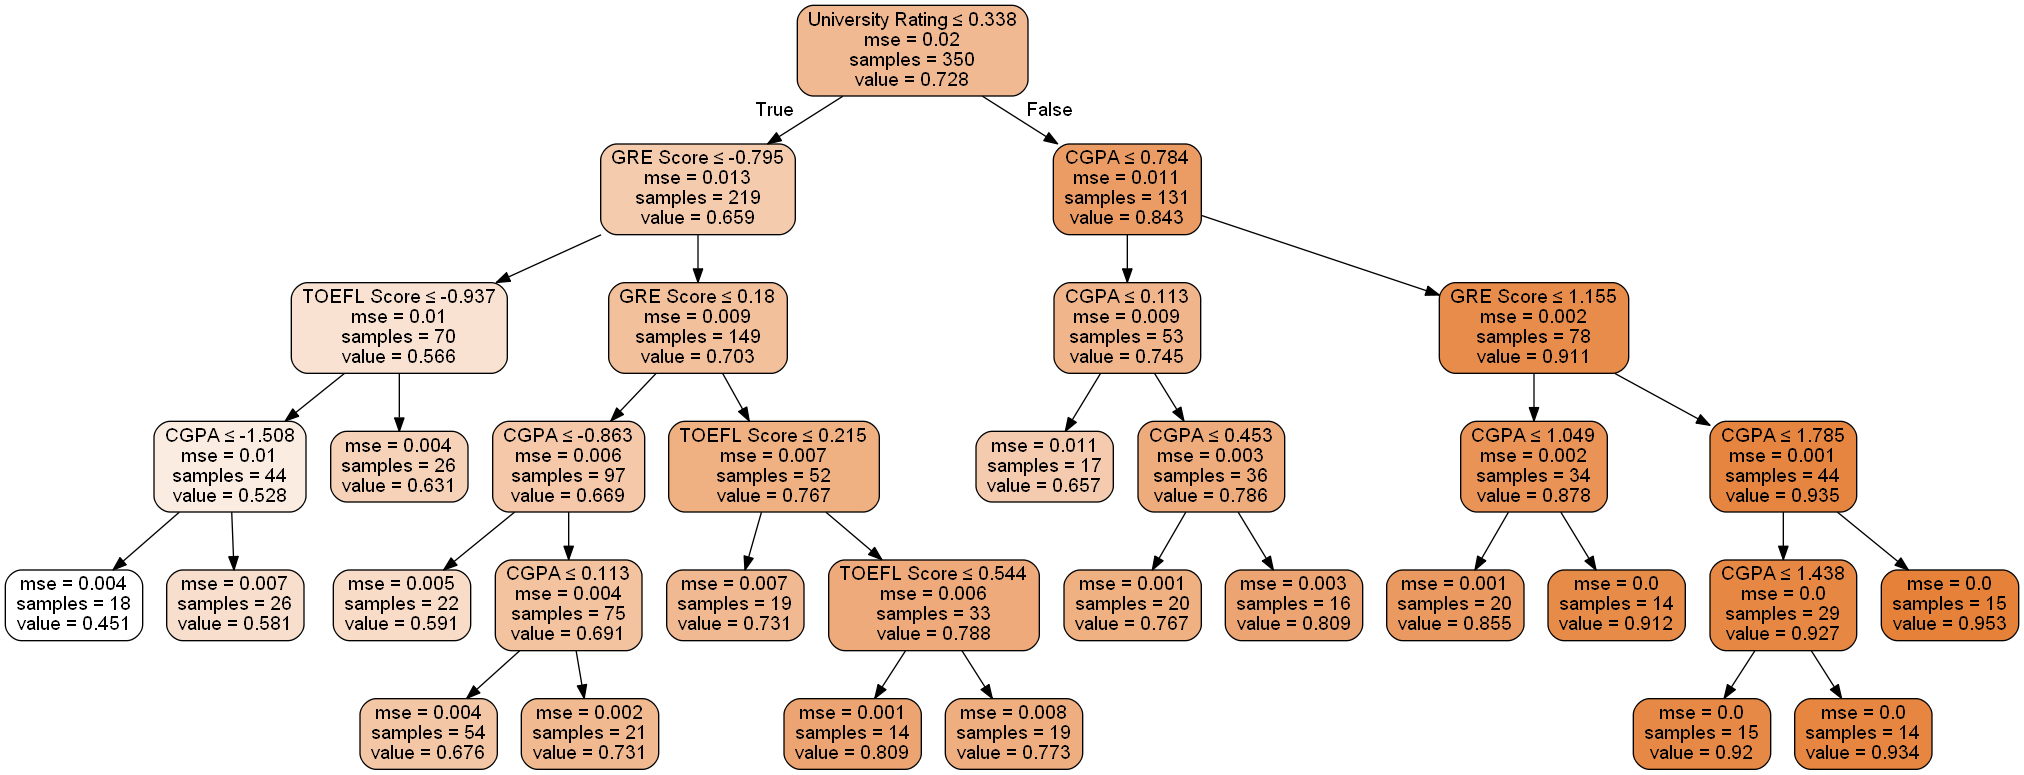

In [35]:
tree1 = DecisionTreeRegressor(random_state=1, \
                              max_depth = grid.best_params_.get('max_depth'),\
                              max_features = grid.best_params_.get('max_features'),\
                              min_samples_leaf = grid.best_params_.get('min_samples_leaf'))
tree1.fit(data_X_train, data_Y_train)
Image(get_png_tree(tree1, data_X_train.columns), height='100%')

In [36]:
tree_full = print_metrics(data_X_train, data_Y_train,  data_X_test, data_Y_test, tree1)

RMSE: 0.005205922348714913, MedianAE: 0.04076923076923067


## Удален 1

Best Param = {'max_depth': 4, 'max_features': 0.8, 'min_samples_leaf': 0.06}, score = -0.0049007423881750655


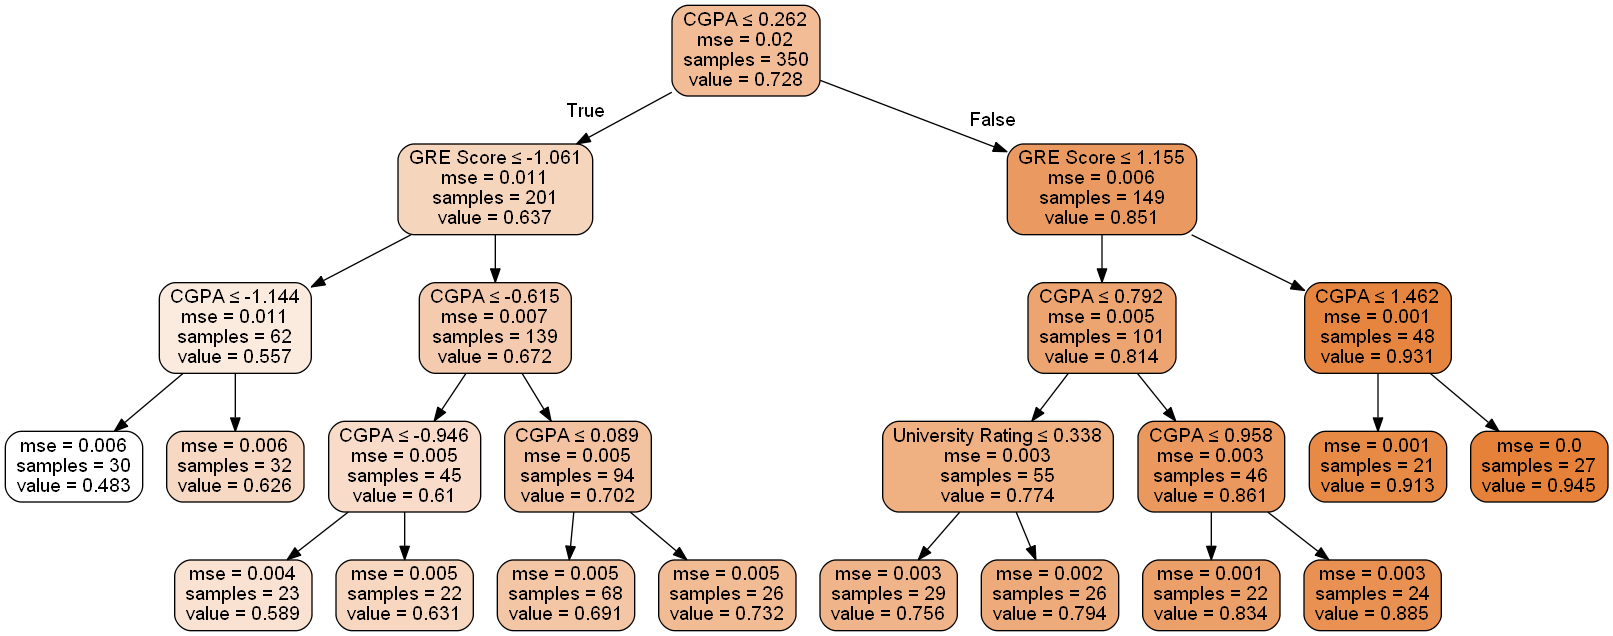

In [37]:
grid.fit(data_d1_X_train, data_d1_Y_train)
print(f'Best Param = {grid.best_params_}, score = {grid.best_score_}')
tree2 = DecisionTreeRegressor(random_state=1, \
                              max_depth = grid.best_params_.get('max_depth'),\
                              max_features = grid.best_params_.get('max_features'),\
                              min_samples_leaf = grid.best_params_.get('min_samples_leaf'))
tree2.fit(data_d1_X_train, data_d1_Y_train)
Image(get_png_tree(tree2, data_d1_X_train.columns), height='100%')

In [38]:
tree_d1 = print_metrics(data_d1_X_train, data_d1_Y_train,  data_d1_X_test, data_d1_Y_test, tree2)

RMSE: 0.005302694813220191, MedianAE: 0.038950534759358224


## Удалено 2

Best Param = {'max_depth': 6, 'max_features': 0.6, 'min_samples_leaf': 0.04}, score = -0.005260788113270196


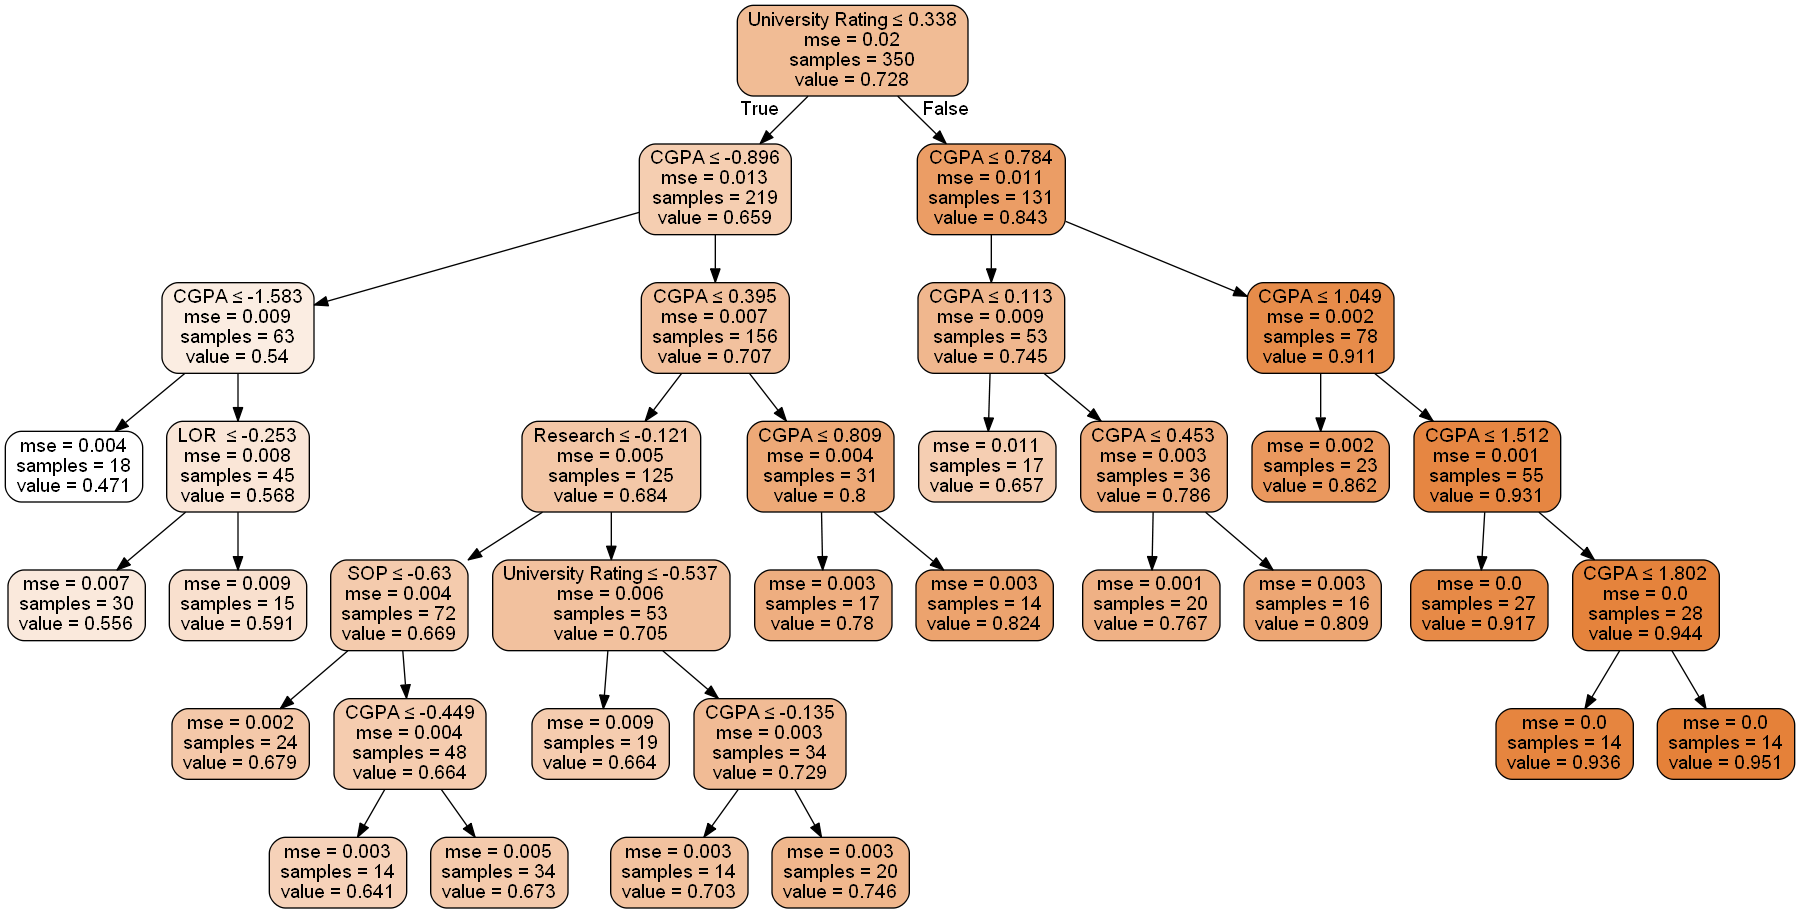

In [39]:
grid.fit(data_d2_X_train, data_d2_Y_train)
print(f'Best Param = {grid.best_params_}, score = {grid.best_score_}')
tree3 = DecisionTreeRegressor(random_state=1, \
                              max_depth = grid.best_params_.get('max_depth'),\
                              max_features = grid.best_params_.get('max_features'),\
                              min_samples_leaf = grid.best_params_.get('min_samples_leaf'))
tree3.fit(data_d2_X_train, data_d2_Y_train)
Image(get_png_tree(tree3, data_d2_X_train.columns), height='100%')

In [40]:
tree_d2 = print_metrics(data_d2_X_train, data_d2_Y_train,  data_d2_X_test, data_d2_Y_test, tree3)

RMSE: 0.004996184197120284, MedianAE: 0.036732804232804284


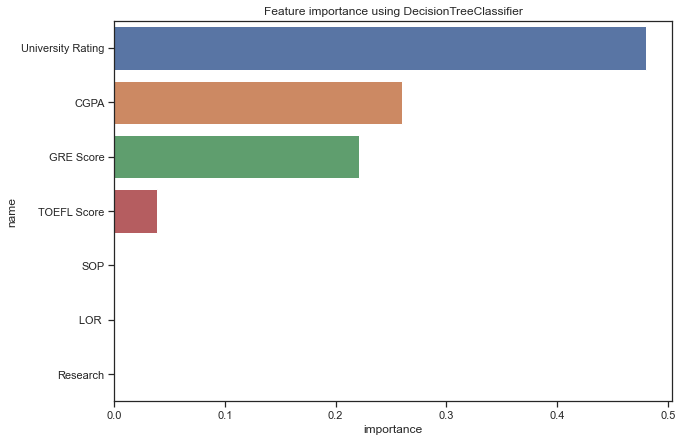

In [41]:
show_feature_importance(tree1.feature_importances_, data_X_test.columns.tolist())

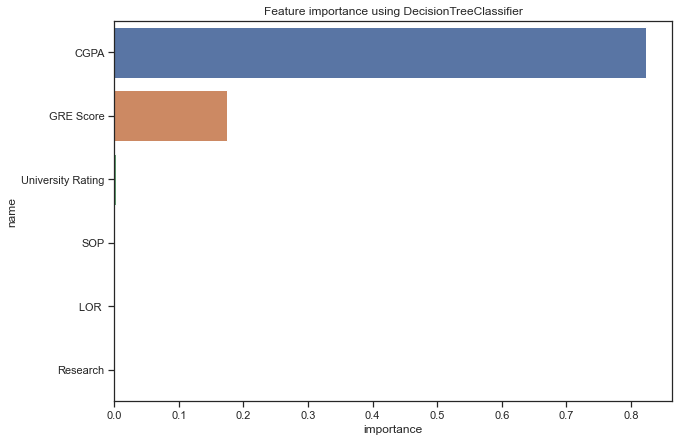

In [42]:
show_feature_importance(tree2.feature_importances_, data_d1_X_test.columns.tolist())

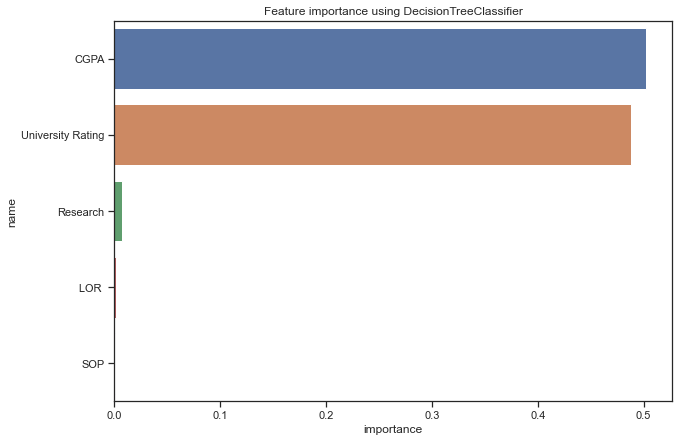

In [43]:
show_feature_importance(tree3.feature_importances_, data_d2_X_test.columns.tolist())

In [44]:
print(f'Полная :{tree_full}')
print(f'Без TOEFL :{tree_d1}')
print(f'Без CGPA :{tree_d2}')

Полная :(0.005205922348714913, 0.04076923076923067)
Без TOEFL :(0.005302694813220191, 0.038950534759358224)
Без CGPA :(0.004996184197120284, 0.036732804232804284)


# итог

In [45]:
print('Linear')
print(f'Полная :{regression_full}')
print(f'Без TOEFL :{regression_d1}')
print(f'Без CGPA :{regression_d2}')
print('Vector')
print(f'Полная :{SVR_full}')
print(f'Без TOEFL :{SVR_d1}')
print(f'Без CGPA :{SVR_d2}')
print('tree')
print(f'Полная :{tree_full}')
print(f'Без TOEFL :{tree_d1}')
print(f'Без CGPA :{tree_d2}')

Linear
Полная :(0.012509480789876208, 0.0670421353882204)
Без TOEFL :(0.018688403265306124, 0.08805714285714283)
Без CGPA :(0.013439982411958144, 0.07315560776015928)
Vector
Полная :(0.004670952294593802, 0.04886169568948162)
Без TOEFL :(0.004856996757379799, 0.05145831076268981)
Без CGPA :(0.005274152109453729, 0.05562094598525846)
tree
Полная :(0.005205922348714913, 0.04076923076923067)
Без TOEFL :(0.005302694813220191, 0.038950534759358224)
Без CGPA :(0.004996184197120284, 0.036732804232804284)


Лучшая точнсть по RMSE у модели SVR для полной таблицы, Лучшая метрика MedianAbsoluteError у DecTree без 2х признаков.